In [12]:
import numpy as np
import pandas as pd

from sklearn import model_selection, preprocessing

from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns

import warnings


nba = pd.read_csv('nba_2013.csv')
nba.index = nba['player'] + ' - ' + nba['bref_team_id']
nba = nba.dropna()




nba.head()

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
Quincy Acy - TOT,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
Arron Afflalo - ORL,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
Alexis Ajinca - NOP,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013
LaMarcus Aldridge - POR,LaMarcus Aldridge,PF,28,POR,69,69,2498,652,1423,0.458,...,599,765,178,63,68,123,147,1603,2013-2014,2013
Lavoy Allen - TOT,Lavoy Allen,PF,24,TOT,65,2,1072,134,300,0.447,...,192,311,71,24,33,44,126,303,2013-2014,2013


col_0  count
pos         
C         53
G          1
PF        74
PG        81
SF        92
SG       102


<Axes: >

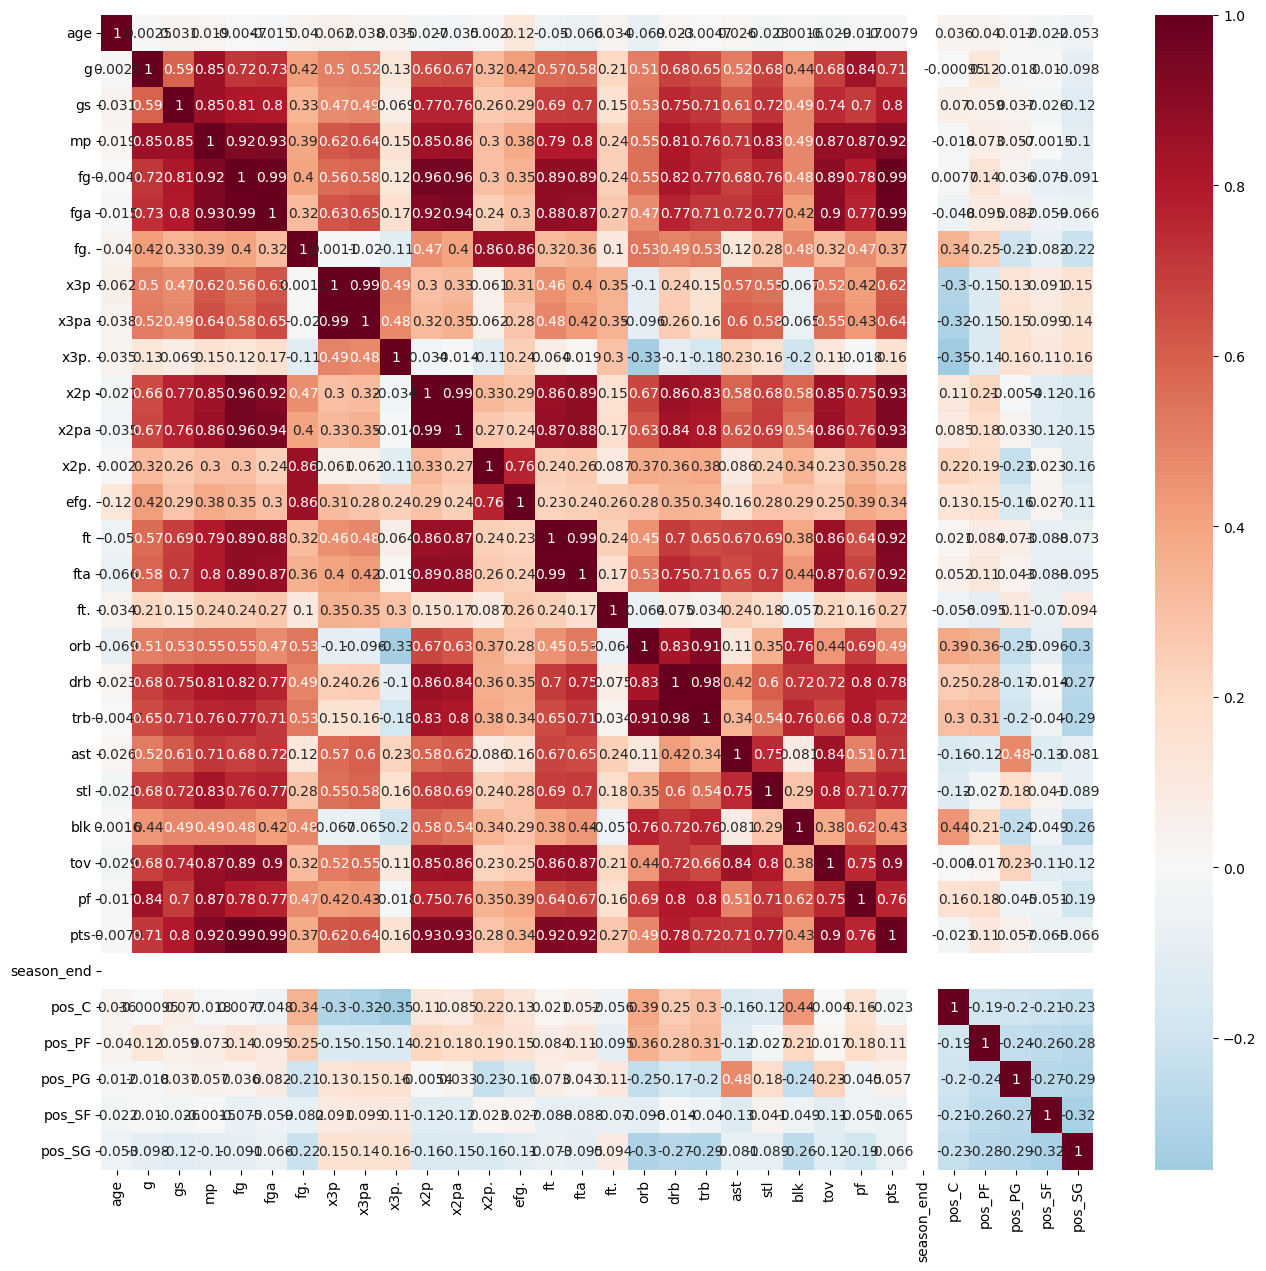

In [13]:

print(pd.crosstab(nba.pos, "count"))

nba = nba[nba.pos != 'G']
pl_pos = nba['pos']

nba.drop(['season', 'player', 'bref_team_id', 'pos'], axis=1, inplace=True)

nba = nba.join(pd.get_dummies(pl_pos, prefix='pos'))
X = nba.drop(['pts','pos_SG'], axis=1)
y = nba['pts']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)


scaler = preprocessing.StandardScaler()

X_train[X_train.columns] = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index)

X_test[X_test.columns] = pd.DataFrame(scaler.transform(X_test), index=X_test.index)


plt.figure(figsize=(16,15))
sns.heatmap(nba.corr(),  annot=True, cmap="RdBu_r", center =0)

In [14]:
model_1 = LinearRegression()
model_1.fit(X_train[['mp']], y_train)

LinearRegression()

In [15]:
print("score train:",model_1.score(X_train[['mp']], y_train))
print("score test:", model_1.score(X_test[['mp']], y_test))

pred = model_1.predict(X_train[['mp']])
pred_test = model_1.predict(X_test[['mp']])

print("rmse train:", np.sqrt(mean_squared_error(y_train, pred)))
print("rmse test: ", np.sqrt(mean_squared_error(y_test, pred_test)))

score train: 0.8402692036105986
score test: 0.866519806391796
rmse train: 188.31349893701935
rmse test:  175.15560128235342


The Elastic Net model is another penalized regression model, for which the penalization coefficient is a linear combination of the L1 and L2 penalties. The model is written as follows :
min𝛽1,…𝛽𝑝∑𝑖=1𝑛(𝑦𝑖−∑𝑖=𝑗𝑝𝛽𝑗𝑥𝑖,𝑗)2+𝛼(𝜆∑𝑖=𝑗𝑝||𝛽𝑗||+(1−𝜆)∑𝑖=𝑗𝑝𝛽2𝑗)
 

The advantages of this combination are mainly the conservation of the variable selection capacity of the Lasso model and the sharing of weights between correlated variables without arbitrary selection.

On Scikit-Learn, the term  𝜆
  is represented by the parameter l1_ratio. An l1_ratio equal to 1 therefore corresponds to a Lasso model, and an l1_ratio equal to 0 corresponds to a Ridge model. Other values between 0 and 1 correspond to a combination of the two regularizations.

The ElasticNetCV function of Scikit-Learn allows you to find the best parameters  𝜆
  and  𝛼
  by cross-validation. Just like LassoCV, it returns a matrix of mean squared errors obtained, but in 3 dimensions (one for the  𝜆
 , one for the  𝛼
  and one for the different stages of the cross-validation).

In [18]:
from sklearn.linear_model import ElasticNetCV

model_en = ElasticNetCV(cv=8, l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99), 
                        alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0), max_iter= 100000)

model_en.fit(X_train, y_train)

ElasticNetCV(alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0),
             cv=8, l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99),
             max_iter=100000)

In [19]:
coeffs = list(model_en.coef_)
coeffs.insert(0, model_en.intercept_)
feats = list(X.columns)
feats.insert(0, 'intercept')

pd.DataFrame({'valeur estimée': coeffs}, index=feats)

,valeur estimée
intercept,600.158879
age,-0.045787
g,-0.043024
gs,-0.164161
mp,0.405563
fg,377.219841
fga,1.410417
fg.,-0.252601
x3p,43.073048
x3pa,-2.095148


In [20]:
pred_train = model_en.predict(X_train)
pred_test = model_en.predict(X_test)
print(np.sqrt(mean_squared_error(y_train, pred_train)))
print(np.sqrt(mean_squared_error(y_test, pred_test)))

0.38041545553617784
0.4852750203305019


In [21]:
print("score train:",model_en.score(X_train, y_train))
print("score test:", model_en.score(X_test, y_test))

score train: 0.9999993481584235
score test: 0.9999989754229102


In [22]:
pd.DataFrame({'Observed points': y_test, 'Predicted points' : np.round(pred_test)}, index = X_test.index).head(10)

,Observed points,Predicted points
Jeremy Evans - UTA,401,401.0
Carlos Boozer - CHI,1042,1042.0
Manu Ginobili - SAS,838,838.0
Amir Johnson - TOR,799,800.0
Francisco Garcia - HOU,315,315.0
Josh Smith - DET,1264,1262.0
Hedo Turkoglu - LAC,115,115.0
John Salmons - TOT,403,403.0
Tyler Zeller - CLE,399,399.0
Archie Goodwin - PHO,194,194.0
